# Recommender System


First, perform data cleaning and feature extraction on the music dataset, using matrix factorization to create music recommendations.

Music Data Processing
Read the music dataset, calculate key metrics, and select valuable information as features for the recommendation model.

Item-Based Similarity Recommendation
Choose a similarity calculation method and use it to generate recommendation results based on item similarity.

Recommendation Based on SVD Matrix Factorization
Use matrix factorization methods to obtain recommendations quickly and efficiently.

In [1]:
import pandas as pd
import numpy as np
import time
import sqlite3

data_home = './'

Our data includes some database files, so we’ll use the sqlite3 library to help us read this data. You can set the data path based on your specific setup.

Let’s first take a look at the structure of our data. For data in different formats, the read_csv function provides many parameters to customize the reading process, such as specifying delimiters and column names.

## Data Loading

Only the user, song, and play count are needed in the data.

In [9]:
triplet_dataset = pd.read_csv(filepath_or_buffer=data_home+'train_triplets.txt', 
                              sep='\t', header=None, 
                              names=['user','song','play_count'])


The dataset is quite large.

In [10]:
triplet_dataset.shape

(48373586, 3)

Memory usage and data format of each metric.

In [11]:
triplet_dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48373586 entries, 0 to 48373585
Data columns (total 3 columns):
user          object
song          object
play_count    int64
dtypes: int64(1), object(2)
memory usage: 1.1+ GB


To gain a more detailed understanding of the data, you can print the .info() of the DataFrame to observe the data types of each column and overall memory usage. Here’s a practical tip: when handling very large datasets, memory overflow errors may occur during processing. A simple solution is to adjust the data formats, such as replacing float64 with float32, which can significantly reduce memory usage.

Original Dataset

In [4]:
triplet_dataset.head(n=10)

,user,song,play_count
0,b80344d063b5ccb3212f76538f3d9e43d87dca9e,SOAKIMP12A8C130995,1
1,b80344d063b5ccb3212f76538f3d9e43d87dca9e,SOAPDEY12A81C210A9,1
2,b80344d063b5ccb3212f76538f3d9e43d87dca9e,SOBBMDR12A8C13253B,2
3,b80344d063b5ccb3212f76538f3d9e43d87dca9e,SOBFNSP12AF72A0E22,1
4,b80344d063b5ccb3212f76538f3d9e43d87dca9e,SOBFOVM12A58A7D494,1
5,b80344d063b5ccb3212f76538f3d9e43d87dca9e,SOBNZDC12A6D4FC103,1
6,b80344d063b5ccb3212f76538f3d9e43d87dca9e,SOBSUJE12A6D4F8CF5,2
7,b80344d063b5ccb3212f76538f3d9e43d87dca9e,SOBVFZR12A6D4F8AE3,1
8,b80344d063b5ccb3212f76538f3d9e43d87dca9e,SOBXALG12A8C13C108,1
9,b80344d063b5ccb3212f76538f3d9e43d87dca9e,SOBXHDL12A81C204C0,1



## Total Play Count for Each User
The data includes the user ID, song ID, and the play count of each song by the user. With this foundational data, we can calculate various metrics about users and songs. For instance, to calculate the total play count for each user, the code is as follows:


In [5]:
output_dict = {}
with open(data_home+'train_triplets.txt') as f:
    for line_number, line in enumerate(f):
        #找到当前的用户
        user = line.split('\t')[0]
        #得到其播放量数据
        play_count = int(line.split('\t')[2])
        #如果字典中已经有该用户信息，在其基础上增加当前的播放量
        if user in output_dict:
            play_count +=output_dict[user]
            output_dict.update({user:play_count})
        output_dict.update({user:play_count})
# 统计 用户-总播放量
output_list = [{'user':k,'play_count':v} for k,v in output_dict.items()]
#转换成DF格式
play_count_df = pd.DataFrame(output_list)
#排序
play_count_df = play_count_df.sort_values(by = 'play_count', ascending = False)

To create a dictionary structure that stores the total play count for each user, we need to iterate over the dataset once. When working with large datasets, each operation can be time-consuming, and a mistake in later steps might mean starting over, which would be very inefficient. It’s best to save intermediate results. Since we have converted the results into a DataFrame format, we can use the to_csv() function to save the data easily.

In [6]:
play_count_df.to_csv(path_or_buf='user_playcount_df.csv', index = False)

## Total Play Count for Each Song

In [7]:
#统计方法跟上述类似
output_dict = {}
with open(data_home+'train_triplets.txt') as f:
    for line_number, line in enumerate(f):
        #找到当前歌曲
        song = line.split('\t')[1]
        #找到当前播放次数
        play_count = int(line.split('\t')[2])
        #统计每首歌曲被播放的总次数
        if song in output_dict:
            play_count +=output_dict[song]
            output_dict.update({song:play_count})
        output_dict.update({song:play_count})
output_list = [{'song':k,'play_count':v} for k,v in output_dict.items()]
#转换成df格式
song_count_df = pd.DataFrame(output_list)
song_count_df = song_count_df.sort_values(by = 'play_count', ascending = False)

In [8]:
song_count_df.to_csv(path_or_buf='song_playcount_df.csv', index = False)

## Let's take a look at the current rankings.

In [8]:
play_count_df = pd.read_csv(filepath_or_buffer='user_playcount_df.csv')
play_count_df.head(n =10)

,play_count,user
0,13132,093cb74eb3c517c5179ae24caf0ebec51b24d2a2
1,9884,119b7c88d58d0c6eb051365c103da5caf817bea6
2,8210,3fa44653315697f42410a30cb766a4eb102080bb
3,7015,a2679496cd0af9779a92a13ff7c6af5c81ea8c7b
4,6494,d7d2d888ae04d16e994d6964214a1de81392ee04
5,6472,4ae01afa8f2430ea0704d502bc7b57fb52164882
6,6150,b7c24f770be6b802805ac0e2106624a517643c17
7,5656,113255a012b2affeab62607563d03fbdf31b08e7
8,5620,6d625c6557df84b60d90426c0116138b617b9449
9,5602,99ac3d883681e21ea68071019dba828ce76fe94d


In [9]:
song_count_df = pd.read_csv(filepath_or_buffer='song_playcount_df.csv')
song_count_df.head(10)

,play_count,song
0,726885,SOBONKR12A58A7A7E0
1,648239,SOAUWYT12A81C206F1
2,527893,SOSXLTC12AF72A7F54
3,425463,SOFRQTD12A81C233C0
4,389880,SOEGIYH12A6D4FC0E3
5,356533,SOAXGDH12A8C13F8A1
6,292642,SONYKOW12AB01849C9
7,274627,SOPUCYA12A8C13A694
8,268353,SOUFTBI12AB0183F65
9,244730,SOVDSJC12A58A7A271


The most popular song has 726,885 plays. As you just saw, this music dataset is quite large. Considering processing time and the sparsity of the matrix, we’ve filtered the dataset based on play count. Some registered users may have just visited the platform briefly and then never returned, which doesn’t help with our modeling and only increases matrix sparsity. The same logic applies to songs, as some may have very low or no engagement.

Since we’ve already ranked users and songs by play count, we selected the top 100,000 users and 30,000 songs. You can also adjust the cut-off proportion by observing the play count and choosing a subset that retains a reasonable proportion of the total play count.

## Take a subset of the data (already sorted by importance), as this likely represents the most significant data, and use it as our experimental dataset.

In [12]:
#10W名用户的播放量占总体的比例
total_play_count = sum(song_count_df.play_count)
print ((float(play_count_df.head(n=100000).play_count.sum())/total_play_count)*100)
play_count_subset = play_count_df.head(n=100000)

40.8807280501


In [13]:
(float(song_count_df.head(n=30000).play_count.sum())/total_play_count)*100

78.39315366645269

In [14]:
song_count_subset = song_count_df.head(n=30000)

The top 30,000 songs account for 78.39% of the total play count. Now that we have 100,000 loyal users and 30,000 classic songs, the next step is to filter and clean the original dataset. In simple terms, this means removing any data from the original dataset that doesn’t include these selected users and songs.

Select 100,000 users and 30,000 songs.

In [16]:
user_subset = list(play_count_subset.user)
song_subset = list(song_count_subset.song)


Filter out data from other users.

In [17]:
#读取原始数据集
triplet_dataset = pd.read_csv(filepath_or_buffer=data_home+'train_triplets.txt',sep='\t', 
                              header=None, names=['user','song','play_count'])
#只保留有这10W名用户的数据，其余过滤掉
triplet_dataset_sub = triplet_dataset[triplet_dataset.user.isin(user_subset) ]
del(triplet_dataset)
#只保留有这3W首歌曲的数据，其余也过滤掉
triplet_dataset_sub_song = triplet_dataset_sub[triplet_dataset_sub.song.isin(song_subset)]
del(triplet_dataset_sub)

In [18]:
triplet_dataset_sub_song.to_csv(path_or_buf=data_home+'triplet_dataset_sub_song.csv', index=False)

To check the current data size after filtering, you can use the following code:

In [19]:
triplet_dataset_sub_song.shape

(10774558, 3)

The number of data samples is now less than a quarter of the original size. However, the filtered samples were all sparse data, which aren’t beneficial for modeling. This shows the importance of data cleaning and preprocessing once we have the data—not only does it speed up computation, but it also positively impacts the final results.

In [20]:
triplet_dataset_sub_song.head(n=10)

,user,song,play_count
498,d6589314c0a9bcbca4fee0c93b14bc402363afea,SOADQPP12A67020C82,12
499,d6589314c0a9bcbca4fee0c93b14bc402363afea,SOAFTRR12AF72A8D4D,1
500,d6589314c0a9bcbca4fee0c93b14bc402363afea,SOANQFY12AB0183239,1
501,d6589314c0a9bcbca4fee0c93b14bc402363afea,SOAYATB12A6701FD50,1
502,d6589314c0a9bcbca4fee0c93b14bc402363afea,SOBOAFP12A8C131F36,7
503,d6589314c0a9bcbca4fee0c93b14bc402363afea,SOBONKR12A58A7A7E0,26
504,d6589314c0a9bcbca4fee0c93b14bc402363afea,SOBZZDU12A6310D8A3,7
505,d6589314c0a9bcbca4fee0c93b14bc402363afea,SOCAHRT12A8C13A1A4,5
506,d6589314c0a9bcbca4fee0c93b14bc402363afea,SODASIJ12A6D4F5D89,1
507,d6589314c0a9bcbca4fee0c93b14bc402363afea,SODEAWL12AB0187032,8


## Adding Detailed Music Information

Currently, we only have play count data, which provides very limited information. Ideally, each song should have detailed information, such as artist, release date, genre, etc. This information is stored in a database file. Next, we’ll use the sqlite3 library to read this data:

In [21]:
conn = sqlite3.connect(data_home+'track_metadata.db')
cur = conn.cursor()
cur.execute("SELECT name FROM sqlite_master WHERE type='table'")
cur.fetchall()

[('songs',)]

In [22]:
track_metadata_df = pd.read_sql(con=conn, sql='select * from songs')
track_metadata_df_sub = track_metadata_df[track_metadata_df.song_id.isin(song_subset)]

In [23]:
track_metadata_df_sub.to_csv(path_or_buf=data_home+'track_metadata_df_sub.csv', index=False)

In [24]:
track_metadata_df_sub.shape

(30447, 14)

## To check the structure and content of our current dataset

In [25]:
triplet_dataset_sub_song = pd.read_csv(filepath_or_buffer=data_home+'triplet_dataset_sub_song.csv',encoding = "ISO-8859-1")
track_metadata_df_sub = pd.read_csv(filepath_or_buffer=data_home+'track_metadata_df_sub.csv',encoding = "ISO-8859-1")

In [26]:
triplet_dataset_sub_song.head()

,user,song,play_count
0,d6589314c0a9bcbca4fee0c93b14bc402363afea,SOADQPP12A67020C82,12
1,d6589314c0a9bcbca4fee0c93b14bc402363afea,SOAFTRR12AF72A8D4D,1
2,d6589314c0a9bcbca4fee0c93b14bc402363afea,SOANQFY12AB0183239,1
3,d6589314c0a9bcbca4fee0c93b14bc402363afea,SOAYATB12A6701FD50,1
4,d6589314c0a9bcbca4fee0c93b14bc402363afea,SOBOAFP12A8C131F36,7


In [27]:
track_metadata_df_sub.head()

,track_id,title,song_id,release,artist_id,artist_mbid,artist_name,duration,artist_familiarity,artist_hotttnesss,year,track_7digitalid,shs_perf,shs_work
0,TRMMGCB128E079651D,Get Along (Feat: Pace Won) (Instrumental),SOHNWIM12A67ADF7D9,Charango,ARU3C671187FB3F71B,067102ea-9519-4622-9077-57ca4164cfbb,Morcheeba,227.47383,0.819087,0.533117,2002,185967,-1,0
1,TRMMGTX128F92FB4D9,Viejo,SOECFIW12A8C144546,Caraluna,ARPAAPH1187FB3601B,f69d655c-ffd6-4bee-8c2a-3086b2be2fc6,Bacilos,307.51302,0.595554,0.400705,0,6825058,-1,0
2,TRMMGDP128F933E59A,I Say A Little Prayer,SOGWEOB12AB018A4D0,The Legendary Hi Records Albums_ Volume 3: Ful...,ARNNRN31187B9AE7B7,fb7272ba-f130-4f0a-934d-6eeea4c18c9a,Al Green,133.58975,0.779490,0.599210,1978,5211723,-1,11898
3,TRMMHBF12903CF6E59,At the Ball_ That's All,SOJGCRL12A8C144187,Best of Laurel & Hardy - The Lonesome Pine,AR1FEUF1187B9AF3E3,4a8ae4fd-ad6f-4912-851f-093f12ee3572,Laurel & Hardy,123.71546,0.438709,0.307120,0,8645877,-1,0
4,TRMMHKG12903CDB1B5,Black Gold,SOHNFBA12AB018CD1D,Total Life Forever,ARVXV1J1187FB5BF88,6a65d878-fcd0-42cf-aff9-ca1d636a8bcc,Foals,386.32444,0.842578,0.514523,2010,9007438,-1,0


## Data Cleaning

Removing unnecessary and duplicate data is a crucial step in data cleaning. It helps reduce noise and improves processing efficiency and model accuracy. Here’s how we can proceed:

In [28]:
# 去掉无用的信息
del(track_metadata_df_sub['track_id'])
del(track_metadata_df_sub['artist_mbid'])
# 去掉重复的
track_metadata_df_sub = track_metadata_df_sub.drop_duplicates(['song_id'])
# 将这份音乐信息数据和我们之前的播放数据整合到一起
triplet_dataset_sub_song_merged = pd.merge(triplet_dataset_sub_song, track_metadata_df_sub, how='left', left_on='song', right_on='song_id')
# 可以自己改变列名
triplet_dataset_sub_song_merged.rename(columns={'play_count':'listen_count'},inplace=True)

In [29]:
# 去掉不需要的指标
del(triplet_dataset_sub_song_merged['song_id'])
del(triplet_dataset_sub_song_merged['artist_id'])
del(triplet_dataset_sub_song_merged['duration'])
del(triplet_dataset_sub_song_merged['artist_familiarity'])
del(triplet_dataset_sub_song_merged['artist_hotttnesss'])
del(triplet_dataset_sub_song_merged['track_7digitalid'])
del(triplet_dataset_sub_song_merged['shs_perf'])
del(triplet_dataset_sub_song_merged['shs_work'])

To check what the cleaned data looks like, we can display a sample and inspect its structure.

In [31]:
triplet_dataset_sub_song_merged.head(n=10)

,user,song,listen_count,title,release,artist_name,year
0,d6589314c0a9bcbca4fee0c93b14bc402363afea,SOADQPP12A67020C82,12,You And Me Jesus,Tribute To Jake Hess,Jake Hess,2004
1,d6589314c0a9bcbca4fee0c93b14bc402363afea,SOAFTRR12AF72A8D4D,1,Harder Better Faster Stronger,Discovery,Daft Punk,2007
2,d6589314c0a9bcbca4fee0c93b14bc402363afea,SOANQFY12AB0183239,1,Uprising,Uprising,Muse,0
3,d6589314c0a9bcbca4fee0c93b14bc402363afea,SOAYATB12A6701FD50,1,Breakfast At Tiffany's,Home,Deep Blue Something,1993
4,d6589314c0a9bcbca4fee0c93b14bc402363afea,SOBOAFP12A8C131F36,7,Lucky (Album Version),We Sing. We Dance. We Steal Things.,Jason Mraz & Colbie Caillat,0
5,d6589314c0a9bcbca4fee0c93b14bc402363afea,SOBONKR12A58A7A7E0,26,You're The One,If There Was A Way,Dwight Yoakam,1990
6,d6589314c0a9bcbca4fee0c93b14bc402363afea,SOBZZDU12A6310D8A3,7,Don't Dream It's Over,Recurring Dream_ Best Of Crowded House (Domest...,Crowded House,1986
7,d6589314c0a9bcbca4fee0c93b14bc402363afea,SOCAHRT12A8C13A1A4,5,S.O.S.,SOS,Jonas Brothers,2007
8,d6589314c0a9bcbca4fee0c93b14bc402363afea,SODASIJ12A6D4F5D89,1,The Invisible Man,The Invisible Man,Michael Cretu,1985
9,d6589314c0a9bcbca4fee0c93b14bc402363afea,SODEAWL12AB0187032,8,American Idiot [feat. Green Day & The Cast Of ...,The Original Broadway Cast Recording 'American...,Green Day,0


The data now looks much more organized. We have not only the play counts of each user for a particular song, but also the song's title, album, artist name, and release date.

To address the "cold start" problem, where we don’t yet have data on a new user’s preferences, we can use a popularity-based recommendation. Let’s identify the most popular songs and artists. Here’s how:

### Display the most popular songs.

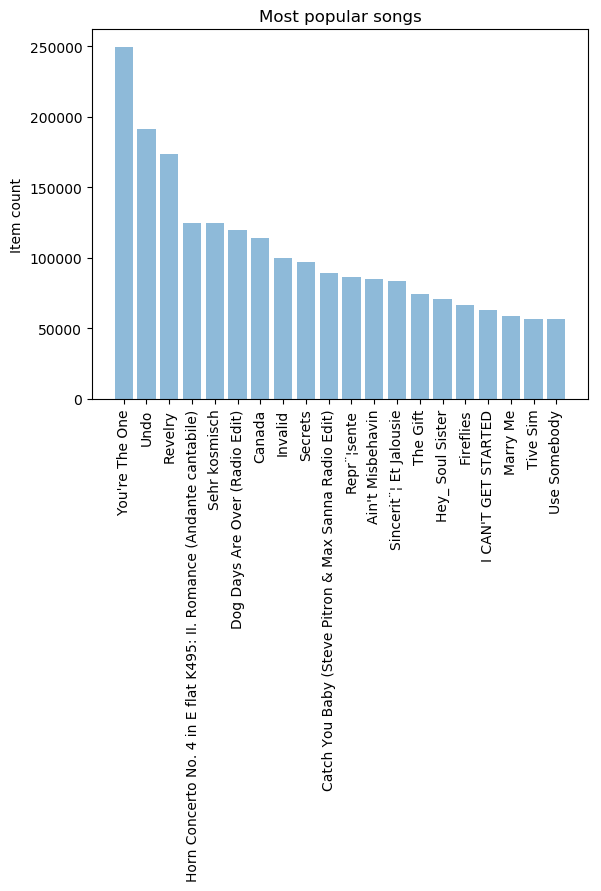

In [32]:
import matplotlib.pyplot as plt; plt.rcdefaults()
import numpy as np
import matplotlib.pyplot as plt
#按歌曲名字来统计其播放量的总数
popular_songs = triplet_dataset_sub_song_merged[['title','listen_count']].groupby('title').sum().reset_index()
#对结果进行排序
popular_songs_top_20 = popular_songs.sort_values('listen_count', ascending=False).head(n=20)

#转换成list格式方便画图
objects = (list(popular_songs_top_20['title']))
#设置位置
y_pos = np.arange(len(objects))
#对应结果值
performance = list(popular_songs_top_20['listen_count'])
#绘图
plt.bar(y_pos, performance, align='center', alpha=0.5)
plt.xticks(y_pos, objects, rotation='vertical')
plt.ylabel('Item count')
plt.title('Most popular songs')
 
plt.show()

Here, we’ve displayed the most popular songs. Using the groupby function, we can easily calculate the play counts for each song, and we’re taking the sum to get the total play count. This ranking data can serve as a list of the most popular songs to recommend to users.

With the same method, we can also calculate the play counts for albums and artists:

### The most popular releases

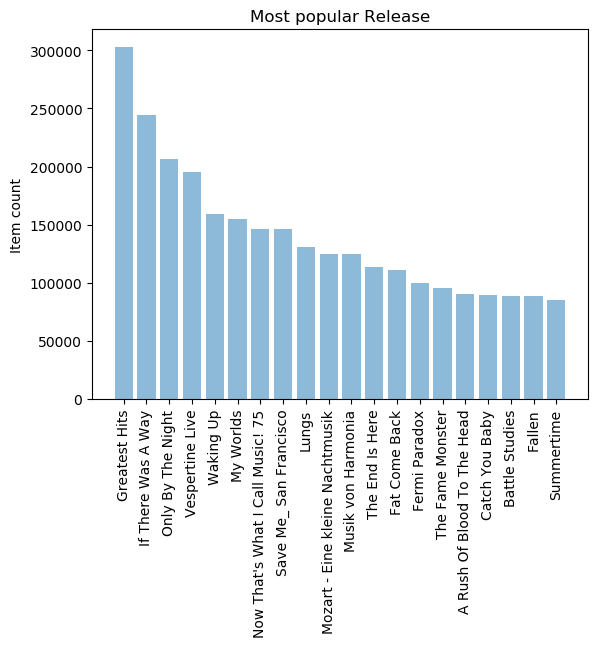

In [33]:
#按专辑名字来统计播放总量
popular_release = triplet_dataset_sub_song_merged[['release','listen_count']].groupby('release').sum().reset_index()
#排序
popular_release_top_20 = popular_release.sort_values('listen_count', ascending=False).head(n=20)

objects = (list(popular_release_top_20['release']))
y_pos = np.arange(len(objects))
performance = list(popular_release_top_20['listen_count'])
#绘图 
plt.bar(y_pos, performance, align='center', alpha=0.5)
plt.xticks(y_pos, objects, rotation='vertical')
plt.ylabel('Item count')
plt.title('Most popular Release')
 
plt.show()

## The most popular singer

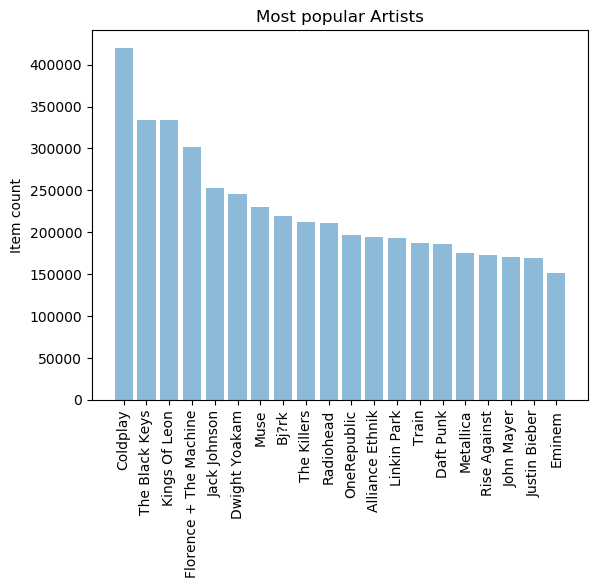

In [34]:
#按歌手来统计其播放总量
popular_artist = triplet_dataset_sub_song_merged[['artist_name','listen_count']].groupby('artist_name').sum().reset_index()
#排序
popular_artist_top_20 = popular_artist.sort_values('listen_count', ascending=False).head(n=20)

objects = (list(popular_artist_top_20['artist_name']))
y_pos = np.arange(len(objects))
performance = list(popular_artist_top_20['listen_count'])
#绘图 
plt.bar(y_pos, performance, align='center', alpha=0.5)
plt.xticks(y_pos, objects, rotation='vertical')
plt.ylabel('Item count')
plt.title('Most popular Artists')
 
plt.show()

## The distribution of the number of songs each user has played

In [35]:
user_song_count_distribution = triplet_dataset_sub_song_merged[['user','title']].groupby('user').count().reset_index().sort_values(
by='title',ascending = False)
user_song_count_distribution.title.describe()

count    99996.000000
mean       107.749890
std         79.742561
min          1.000000
25%         53.000000
50%         89.000000
75%        141.000000
max       1189.000000
Name: title, dtype: float64

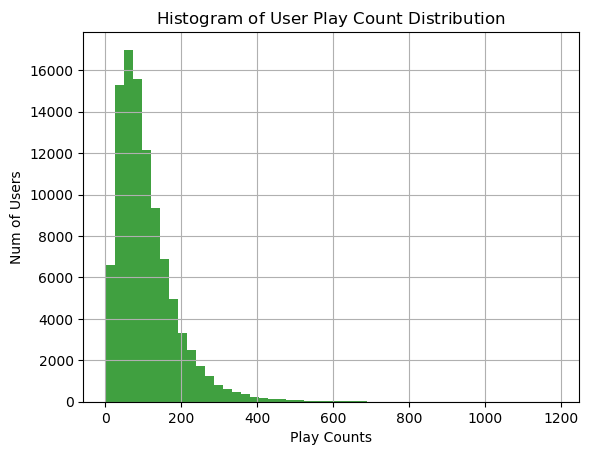

In [36]:
x = user_song_count_distribution.title
n, bins, patches = plt.hist(x, 50, facecolor='green', alpha=0.75)
plt.xlabel('Play Counts')
plt.ylabel('Num of Users')
plt.title(r'$\mathrm{Histogram\ of\ User\ Play\ Count\ Distribution}\ $')
plt.grid(True)
plt.show()

Most users have played around 100 songs. We've covered the data processing and overview thoroughly. Now, our next step is to build a program capable of making real recommendations.

## Start building the recommendation system

In [38]:
import Recommenders as Recommenders
from sklearn.model_selection import train_test_split

## Simple and Effective: Ranking-Based Recommendations for New Users (Cold Start Solution)
The simplest recommendation approach is using a popularity-based ranking list. This method is effective for new users, addressing the cold start problem. Here, we’ll create a function that takes in the raw data, user column name, and a target metric (e.g., song title, artist, or album name) to generate the ranking list:

In [39]:
triplet_dataset_sub_song_merged_set = triplet_dataset_sub_song_merged
train_data, test_data = train_test_split(triplet_dataset_sub_song_merged_set, test_size = 0.40, random_state=0)

In [40]:
train_data.head()

,user,song,listen_count,title,release,artist_name,year
1901799,28866ea8a809d5d46273cd0989c5515c660ef8c7,SOEYVHS12AB0181D31,1,Monster,The Fame Monster,Lady GaGa,2009
4815185,c9608a24a2a40e0ec38993a70532e7bb56eff22b,SOKIYKQ12A8AE464FC,2,Fight For Your Life,Made In NYC,The Casualties,2000
10513026,24f0b09c133a6a0fe42f097734215dceb468d449,SOETFVO12AB018DFF3,1,Free Style (feat. Kevo_ Mussilini & Lyrical 187),A Bad Azz Mix Tape,Z-RO,0
2659073,4da3c59a0af73245cea000fd5efa30384182bfcb,SOAXJOU12A6D4F6685,1,Littlest Things,Alright_ Still,Lily Allen,2006
5506263,b46c5ed385cad7ecea8af6214f440d19de6eb6c2,SOXBCAY12AB0189EE0,1,La trama y el desenlace,Amar la trama,Jorge Drexler,2010


In [41]:
def create_popularity_recommendation(train_data, user_id, item_id):
    #根据指定的特征来统计其播放情况，可以选择歌曲名，专辑名，歌手名
    train_data_grouped = train_data.groupby([item_id]).agg({user_id: 'count'}).reset_index()
    #为了直观展示，我们用得分来表示其结果
    train_data_grouped.rename(columns = {user_id: 'score'},inplace=True)
    
    #排行榜单需要排序
    train_data_sort = train_data_grouped.sort_values(['score', item_id], ascending = [0,1])
    
    #加入一项排行等级，表示其推荐的优先级
    train_data_sort['Rank'] = train_data_sort['score'].rank(ascending=0, method='first')
        
    #返回指定个数的推荐结果
    popularity_recommendations = train_data_sort.head(20)
    return popularity_recommendations

In [42]:
recommendations = create_popularity_recommendation(triplet_dataset_sub_song_merged,'user','title')

Recommandation Results

In [43]:
recommendations

,title,score,Rank
19601,Sehr kosmisch,18626,1.0
5797,Dog Days Are Over (Radio Edit),17635,2.0
27332,You're The One,16085,3.0
19563,Secrets,15138,4.0
18653,Revelry,14945,5.0
25087,Undo,14687,6.0
7547,Fireflies,13085,7.0
9659,Hey_ Soul Sister,12993,8.0
25233,Use Somebody,12793,9.0
9940,Horn Concerto No. 4 in E flat K495: II. Romanc...,12346,10.0


The function returned a top 20 song ranking, with scores based simply on play count. In designing a more robust ranking, you could incorporate additional metrics, such as song release year, artist popularity, and more, to create a composite score.

## Song similarity-based recommendations

Now, we’ll proceed with calculating similarity to recommend songs. To speed up the code execution, we’ll use a subset of the data for our experiments.

In [44]:
song_count_subset = song_count_df.head(n=5000)
user_subset = list(play_count_subset.user)
song_subset = list(song_count_subset.song)
triplet_dataset_sub_song_merged_sub = triplet_dataset_sub_song_merged[triplet_dataset_sub_song_merged.song.isin(song_subset)]

In [45]:
triplet_dataset_sub_song_merged_sub.head()

,user,song,listen_count,title,release,artist_name,year
0,d6589314c0a9bcbca4fee0c93b14bc402363afea,SOADQPP12A67020C82,12,You And Me Jesus,Tribute To Jake Hess,Jake Hess,2004
1,d6589314c0a9bcbca4fee0c93b14bc402363afea,SOAFTRR12AF72A8D4D,1,Harder Better Faster Stronger,Discovery,Daft Punk,2007
2,d6589314c0a9bcbca4fee0c93b14bc402363afea,SOANQFY12AB0183239,1,Uprising,Uprising,Muse,0
3,d6589314c0a9bcbca4fee0c93b14bc402363afea,SOAYATB12A6701FD50,1,Breakfast At Tiffany's,Home,Deep Blue Something,1993
4,d6589314c0a9bcbca4fee0c93b14bc402363afea,SOBOAFP12A8C131F36,7,Lucky (Album Version),We Sing. We Dance. We Steal Things.,Jason Mraz & Colbie Caillat,0


### Song similarities and generate recommendations based on these results

In [46]:
import Recommenders as Recommenders
train_data, test_data = train_test_split(triplet_dataset_sub_song_merged_sub, test_size = 0.30, random_state=0)
is_model = Recommenders.item_similarity_recommender_py()
is_model.create(train_data, 'user', 'title')
user_id = list(train_data.user)[7]
user_items = is_model.get_user_items(user_id)

You may have noticed that we first imported Recommenders, which is a custom utility package containing all the functions we’ll use next. Since the upcoming code for calculations is quite extensive, displaying it directly in the notebook would be inconvenient, so we created a .py file where all the actual computation happens.

When working with this code yourself, it’s best to choose a suitable IDE, as notebooks don’t support debugging. When dealing with a new and relatively large codebase, it’s recommended to execute the code line by line using debugging. This way, you can more clearly understand what each function does. Looking at the entire code at once can be overwhelming, especially for beginners. Using a reliable IDE, such as PyCharm or Eclipse, can be very helpful.

The overall codebase is still quite large, so I’ll first explain what it accomplishes. As you work through the code, it’s best to debug line-by-line, as I mentioned before.

The goal is to recommend songs for a specific user by finding songs similar to those they’ve already listened to. To do this, we first need to identify the songs the user has played. Then, by comparing these songs to all other songs in the dataset, we can recommend songs that are most similar to what the user has already enjoyed.

### How Does This Work?

1. **Identify Songs Listened To**: For a given user, we list all the songs they have already listened to.

2. **Build a Similarity Matrix**: 
   - Suppose the user has listened to 66 songs, and the full dataset contains 4,879 songs.
   - We’ll construct a `[66, 4879]` matrix, where each value represents the similarity between each song the user has listened to and each song in the dataset.
   - Here, we use the **Jaccard Similarity Coefficient**. The value at `[i, j]` in the matrix represents how similar the i-th song that the user has listened to is to the j-th song in the dataset.

3. **Calculate Jaccard Similarity**:
   - To calculate the similarity between two songs, we look at the audience overlap.
   - For example, if 3,000 people have listened to song `i` and 5,000 people have listened to song `j`, the Jaccard Similarity is calculated as:

   \[
   \text{Jaccard Similarity} = \frac{\text{Number of users who listened to both songs}}{\text{Number of users who listened to either song}}
   \]

   - If two songs have a high Jaccard score, they share a similar audience, making them good candidates for recommendation.

4. **Aggregate Scores for Each Song**:
   - For each song in the dataset (e.g., song `j`), calculate its similarity with all 66 songs the user has already listened to.
   - To determine the final recommendation score for song `j`, we sum the Jaccard values and compute the average. This average score represents the song’s overall recommendation score for that user.

5. **Recommend Based on Scores**:
   - Sort the songs by their recommendation scores and suggest the top-ranked songs as recommendations.

This process ensures that songs recommended to the user have audiences that overlap with the user’s interests, making it more likely that they’ll enjoy the recommended tracks. This method also accounts for the distribution of each song’s audience, giving a balanced recommendation based on shared interests.







In [47]:
#执行推荐
is_model.recommend(user_id)

No. of unique songs for the user: 66
no. of unique songs in the training set: 4879
Non zero values in cooccurence_matrix :290327


,user_id,song,score,rank
0,a974fc428825ed071281302d6976f59bfa95fe7e,Put Your Head On My Shoulder (Album Version),0.026334,1
1,a974fc428825ed071281302d6976f59bfa95fe7e,The Strength To Go On,0.025176,2
2,a974fc428825ed071281302d6976f59bfa95fe7e,Come Fly With Me (Album Version),0.024447,3
3,a974fc428825ed071281302d6976f59bfa95fe7e,Moondance (Album Version),0.024118,4
4,a974fc428825ed071281302d6976f59bfa95fe7e,Kotov Syndrome,0.023311,5
5,a974fc428825ed071281302d6976f59bfa95fe7e,Use Somebody,0.023104,6
6,a974fc428825ed071281302d6976f59bfa95fe7e,Lucky (Album Version),0.022930,7
7,a974fc428825ed071281302d6976f59bfa95fe7e,Secrets,0.022889,8
8,a974fc428825ed071281302d6976f59bfa95fe7e,Clocks,0.022562,9
9,a974fc428825ed071281302d6976f59bfa95fe7e,Sway (Album Version),0.022359,10


## Recommendation Based on Matrix Factorization (SVD)

While similarity-based methods are straightforward to implement, they become computationally expensive for large datasets, as each user requires multiple passes over the entire dataset. Matrix factorization is a more commonly used approach in such cases.

**Singular Value Decomposition (SVD)** is a classic method in matrix factorization. We can use SVD for recommendation, as it is designed to break down a large matrix into smaller matrices. This approach is similar to the concept behind latent factor models we discussed earlier, where a large matrix is represented by a combination of smaller matrices. The basic structure of SVD is shown below:

---

<img src="1.png" style="width:550px;height:280px;float:left">
<img src="5.png" style="width:350px;height:280px;float:left">

We do SVD and get matrices U, S, and V.

<img src="2.png" style="width:500px;height:380px;float:left"><img src="3.png" style="width:400px;height:200px;float:left">

To recompute the result of \( U * S * V \) and obtain a new matrix \( A2 \), we can then compare \( A2 \) with the original matrix \( A \). Although there is a difference, it’s typically not large, which means we can use \( A2 \) as an approximate representation of \( A \).

### Steps:

1. **Compute \( A2 \)**:
   - Using SVD, decompose \( A \) into \( U \), \( S \), and \( V \) matrices.
   - Multiply \( U \), \( S \), and \( V \) together to reconstruct \( A2 \).

2. **Compare \( A2 \) with \( A \)**:
   - Calculate the difference between \( A \) and \( A2 \) to assess how close \( A2 \) is to the original.

<img src="4.png" style="width:330px;height:220px;float:left">
<img src="5.png" style="width:330px;height:220px;float:left">

<img src="6.png" style="width:650px;height:480px;float:left">

<img src="7.png" style="width:650px;height:480px;float:left">

In SVD, we typically need user ratings for items. However, in our current dataset, we only have information on song plays by each user, not actual ratings. Therefore, we need to define a rating score for each user-song pair.

If a user likes a song, they’re likely to play it often; conversely, if they don’t like a song, the play count will likely be lower.

We’ll define the user’s rating for each song as:

\[
\text{User rating for a song} = \frac{\text{Play count for the song by the user}}{\text{Total play count for the user}}
\]

In [48]:
triplet_dataset_sub_song_merged_sum_df = triplet_dataset_sub_song_merged[['user','listen_count']].groupby('user').sum().reset_index()
triplet_dataset_sub_song_merged_sum_df.rename(columns={'listen_count':'total_listen_count'},inplace=True)
triplet_dataset_sub_song_merged = pd.merge(triplet_dataset_sub_song_merged,triplet_dataset_sub_song_merged_sum_df)
triplet_dataset_sub_song_merged.head()

,user,song,listen_count,title,release,artist_name,year,total_listen_count
0,d6589314c0a9bcbca4fee0c93b14bc402363afea,SOADQPP12A67020C82,12,You And Me Jesus,Tribute To Jake Hess,Jake Hess,2004,329
1,d6589314c0a9bcbca4fee0c93b14bc402363afea,SOAFTRR12AF72A8D4D,1,Harder Better Faster Stronger,Discovery,Daft Punk,2007,329
2,d6589314c0a9bcbca4fee0c93b14bc402363afea,SOANQFY12AB0183239,1,Uprising,Uprising,Muse,0,329
3,d6589314c0a9bcbca4fee0c93b14bc402363afea,SOAYATB12A6701FD50,1,Breakfast At Tiffany's,Home,Deep Blue Something,1993,329
4,d6589314c0a9bcbca4fee0c93b14bc402363afea,SOBOAFP12A8C131F36,7,Lucky (Album Version),We Sing. We Dance. We Steal Things.,Jason Mraz & Colbie Caillat,0,329


In [49]:
triplet_dataset_sub_song_merged['fractional_play_count'] = triplet_dataset_sub_song_merged['listen_count']/triplet_dataset_sub_song_merged['total_listen_count']

In [50]:
triplet_dataset_sub_song_merged[triplet_dataset_sub_song_merged.user =='d6589314c0a9bcbca4fee0c93b14bc402363afea'][['user','song','listen_count','fractional_play_count']].head()

,user,song,listen_count,fractional_play_count
0,d6589314c0a9bcbca4fee0c93b14bc402363afea,SOADQPP12A67020C82,12,0.036474
1,d6589314c0a9bcbca4fee0c93b14bc402363afea,SOAFTRR12AF72A8D4D,1,0.003040
2,d6589314c0a9bcbca4fee0c93b14bc402363afea,SOANQFY12AB0183239,1,0.003040
3,d6589314c0a9bcbca4fee0c93b14bc402363afea,SOAYATB12A6701FD50,1,0.003040
4,d6589314c0a9bcbca4fee0c93b14bc402363afea,SOBOAFP12A8C131F36,7,0.021277


In [51]:
from scipy.sparse import coo_matrix

small_set = triplet_dataset_sub_song_merged
user_codes = small_set.user.drop_duplicates().reset_index()
song_codes = small_set.song.drop_duplicates().reset_index()
user_codes.rename(columns={'index':'user_index'}, inplace=True)
song_codes.rename(columns={'index':'song_index'}, inplace=True)
song_codes['so_index_value'] = list(song_codes.index)
user_codes['us_index_value'] = list(user_codes.index)
small_set = pd.merge(small_set,song_codes,how='left')
small_set = pd.merge(small_set,user_codes,how='left')
mat_candidate = small_set[['us_index_value','so_index_value','fractional_play_count']]
data_array = mat_candidate.fractional_play_count.values
row_array = mat_candidate.us_index_value.values
col_array = mat_candidate.so_index_value.values

data_sparse = coo_matrix((data_array, (row_array, col_array)),dtype=float)

In [52]:
data_sparse

<99996x30000 sparse matrix of type '<class 'numpy.float64'>'
	with 10774558 stored elements in COOrdinate format>

In the code above, we first group by user to calculate each user's total play count. Then, we divide each song's play count by the user's total to get a score for each song. The final column, `fractional_play_count`, represents the user’s rating for each song.

Now that we have rating values, we can build the user-item matrix. However, there are a few small issues to address: in the raw data, both user IDs and song IDs are lengthy and cumbersome to work with directly. We’ll create new indices for each to make it easier to represent them in the matrix.

In [53]:
user_codes[user_codes.user =='2a2f776cbac6df64d6cb505e7e834e01684673b6']

,user_index,user,us_index_value
27516,2981434,2a2f776cbac6df64d6cb505e7e834e01684673b6,27516


### Using SVD for Matrix Factorization

Once the matrix is constructed, we can proceed with SVD for matrix factorization. For this, we’ll use additional libraries to help with computation. `scipy` is particularly useful here, as it provides built-in SVD functions that make the process easier.



In [54]:
import math as mt
from scipy.sparse.linalg import * #used for matrix multiplication
from scipy.sparse.linalg import svds
from scipy.sparse import csc_matrix

In [55]:
def compute_svd(urm, K):
    U, s, Vt = svds(urm, K)

    dim = (len(s), len(s))
    S = np.zeros(dim, dtype=np.float32)
    for i in range(0, len(s)):
        S[i,i] = mt.sqrt(s[i])

    U = csc_matrix(U, dtype=np.float32)
    S = csc_matrix(S, dtype=np.float32)
    Vt = csc_matrix(Vt, dtype=np.float32)
    
    return U, S, Vt

def compute_estimated_matrix(urm, U, S, Vt, uTest, K, test):
    rightTerm = S*Vt 
    max_recommendation = 250
    estimatedRatings = np.zeros(shape=(MAX_UID, MAX_PID), dtype=np.float16)
    recomendRatings = np.zeros(shape=(MAX_UID,max_recommendation ), dtype=np.float16)
    for userTest in uTest:
        prod = U[userTest, :]*rightTerm
        estimatedRatings[userTest, :] = prod.todense()
        recomendRatings[userTest, :] = (-estimatedRatings[userTest, :]).argsort()[:max_recommendation]
    return recomendRatings

When performing SVD, we need to specify an additional parameter: the **K value**. This parameter determines the number of top singular values we select as an approximate representation, corresponding to the number of components in the `S` matrix.

- A **larger K value** yields results closer to the original data but slows down computation.
- A **smaller K value** speeds up computation but may result in a less accurate approximation.

Choosing the right K value is a trade-off between accuracy and efficiency, so it’s important to experiment and find a value that balances both for your specific use case.


In [56]:
K=50
urm = data_sparse
MAX_PID = urm.shape[1]
MAX_UID = urm.shape[0]

U, S, Vt = compute_svd(urm, K)

Here, we choose a **K value of 50**, where PID represents the subset of selected songs, and UID represents the subset of selected users.

During execution, you can print the dimensions of each matrix. It’s highly recommended to copy the code into an IDE and use breakpoints to step through the code line-by-line, observing the values of each variable. This will greatly aid in understanding the process.

Next, we need to select users for testing:

```python
uTest = [4, 5, 6, 7, 8, 873, 23]
‘’‘
You can choose any set of users; here, the list represents user indices. For each user, we’ll calculate their preference for the 30,000 songs in our candidate pool. Essentially, we’ll estimate their rating scores for each of these songs. Using SVD, we’ve already obtained the smaller matrices we need, and now we can reconstruct the matrix to get our predictions:

In [57]:
uTest = [4,5,6,7,8,873,23]

uTest_recommended_items = compute_estimated_matrix(urm, U, S, Vt, uTest, K, True)

In [58]:
for user in uTest:
    print("Recommendation for user with user id {}". format(user))
    rank_value = 1
    for i in uTest_recommended_items[user,0:10]:
        song_details = small_set[small_set.so_index_value == i].drop_duplicates('so_index_value')[['title','artist_name']]
        print("The number {} recommended song is {} BY {}".format(rank_value, list(song_details['title'])[0],list(song_details['artist_name'])[0]))
        rank_value+=1

Recommendation for user with user id 4
The number 1 recommended song is Fireflies BY Charttraxx Karaoke
The number 2 recommended song is Hey_ Soul Sister BY Train
The number 3 recommended song is OMG BY Usher featuring will.i.am
The number 4 recommended song is Lucky (Album Version) BY Jason Mraz & Colbie Caillat
The number 5 recommended song is Vanilla Twilight BY Owl City
The number 6 recommended song is Crumpshit BY Philippe Rochard
The number 7 recommended song is Billionaire [feat. Bruno Mars]  (Explicit Album Version) BY Travie McCoy
The number 8 recommended song is Love Story BY Taylor Swift
The number 9 recommended song is TULENLIEKKI BY M.A. Numminen
The number 10 recommended song is Use Somebody BY Kings Of Leon
Recommendation for user with user id 5
The number 1 recommended song is Sehr kosmisch BY Harmonia
The number 2 recommended song is Ain't Misbehavin BY Sam Cooke
The number 3 recommended song is Dog Days Are Over (Radio Edit) BY Florence + The Machine
The number 4 reco

For each user, we obtained their corresponding recommendation results and sorted these results by score.

In this chapter, we used a music dataset to complete a personalized recommendation task. We first preprocessed and integrated the data, then selected two different methods to accomplish the recommendation task.

1. **Similarity-Based Recommendation**: In this approach, we recommend songs from the candidate pool that are most similar to those the user has already listened to. However, this method is computationally expensive, as each user's recommendations require recalculating similarities across the entire dataset.

2. **SVD Matrix Factorization**: 
   - We started by constructing a user-item rating matrix.
   - Then, we performed SVD decomposition on this matrix.
   - For each user to be recommended to, we reconstructed their estimated ratings for all songs.
   - Finally, we sorted these estimated ratings to return the top recommendations.

The SVD approach provides a more efficient way to generate recommendations, as it avoids repeatedly calculating similarities for each user and instead leverages latent features to estimate preferences.


In [59]:
uTest = [27513]
#Get estimated rating for test user
print("Predictied ratings:")
uTest_recommended_items = compute_estimated_matrix(urm, U, S, Vt, uTest, K, True)

Predictied ratings:


In [60]:
for user in uTest:
    print("Recommendation for user with user id {}". format(user))
    rank_value = 1
    for i in uTest_recommended_items[user,0:10]:
        song_details = small_set[small_set.so_index_value == i].drop_duplicates('so_index_value')[['title','artist_name']]
        print("The number {} recommended song is {} BY {}".format(rank_value, list(song_details['title'])[0],list(song_details['artist_name'])[0]))
        rank_value+=1

Recommendation for user with user id 27513
The number 1 recommended song is Master Of Puppets BY Metallica
The number 2 recommended song is Garden Of Eden BY Guns N' Roses
The number 3 recommended song is Bring Me To Life BY Evanescence
The number 4 recommended song is Kryptonite BY 3 Doors Down
The number 5 recommended song is Make Her Say BY Kid Cudi / Kanye West / Common
The number 6 recommended song is Night Village BY Deep Forest
The number 7 recommended song is Savior BY Rise Against
The number 8 recommended song is Good Things BY Rich Boy / Polow Da Don / Keri Hilson
The number 9 recommended song is Bleed It Out [Live At Milton Keynes] BY Linkin Park
The number 10 recommended song is Uprising BY Muse
